# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using {} to cluster them.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.clustering import BoxDiscretization

import warnings; warnings.simplefilter('ignore')

### Import the data 

In [2]:
# import omega data
omegas = np.load('omega_data/omegas_rep0.npy')
print(omegas)
print(f"omegas.shape: {omegas.shape}")
print(f"omegas.dtype: {omegas.dtype}")

[[-131.94534302 -164.36683655 -168.73222351 ...  155.54360962
   169.69421387 -178.63116455]
 [-167.89039612 -177.17208862  162.46188354 ...  149.18318176
  -159.73303223 -144.30940247]
 [ 157.45036316 -173.79418945  160.29325867 ...  148.97602844
  -175.55055237 -138.37025452]
 ...
 [  11.94939327 -160.49836731  152.62150574 ...   -9.61826515
   174.22305298  -29.52038193]
 [  -4.24486399 -175.47666931  170.79945374 ...  -27.82961082
  -154.78591919  -34.27692413]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
omegas.shape: (30001, 9)
omegas.dtype: float64


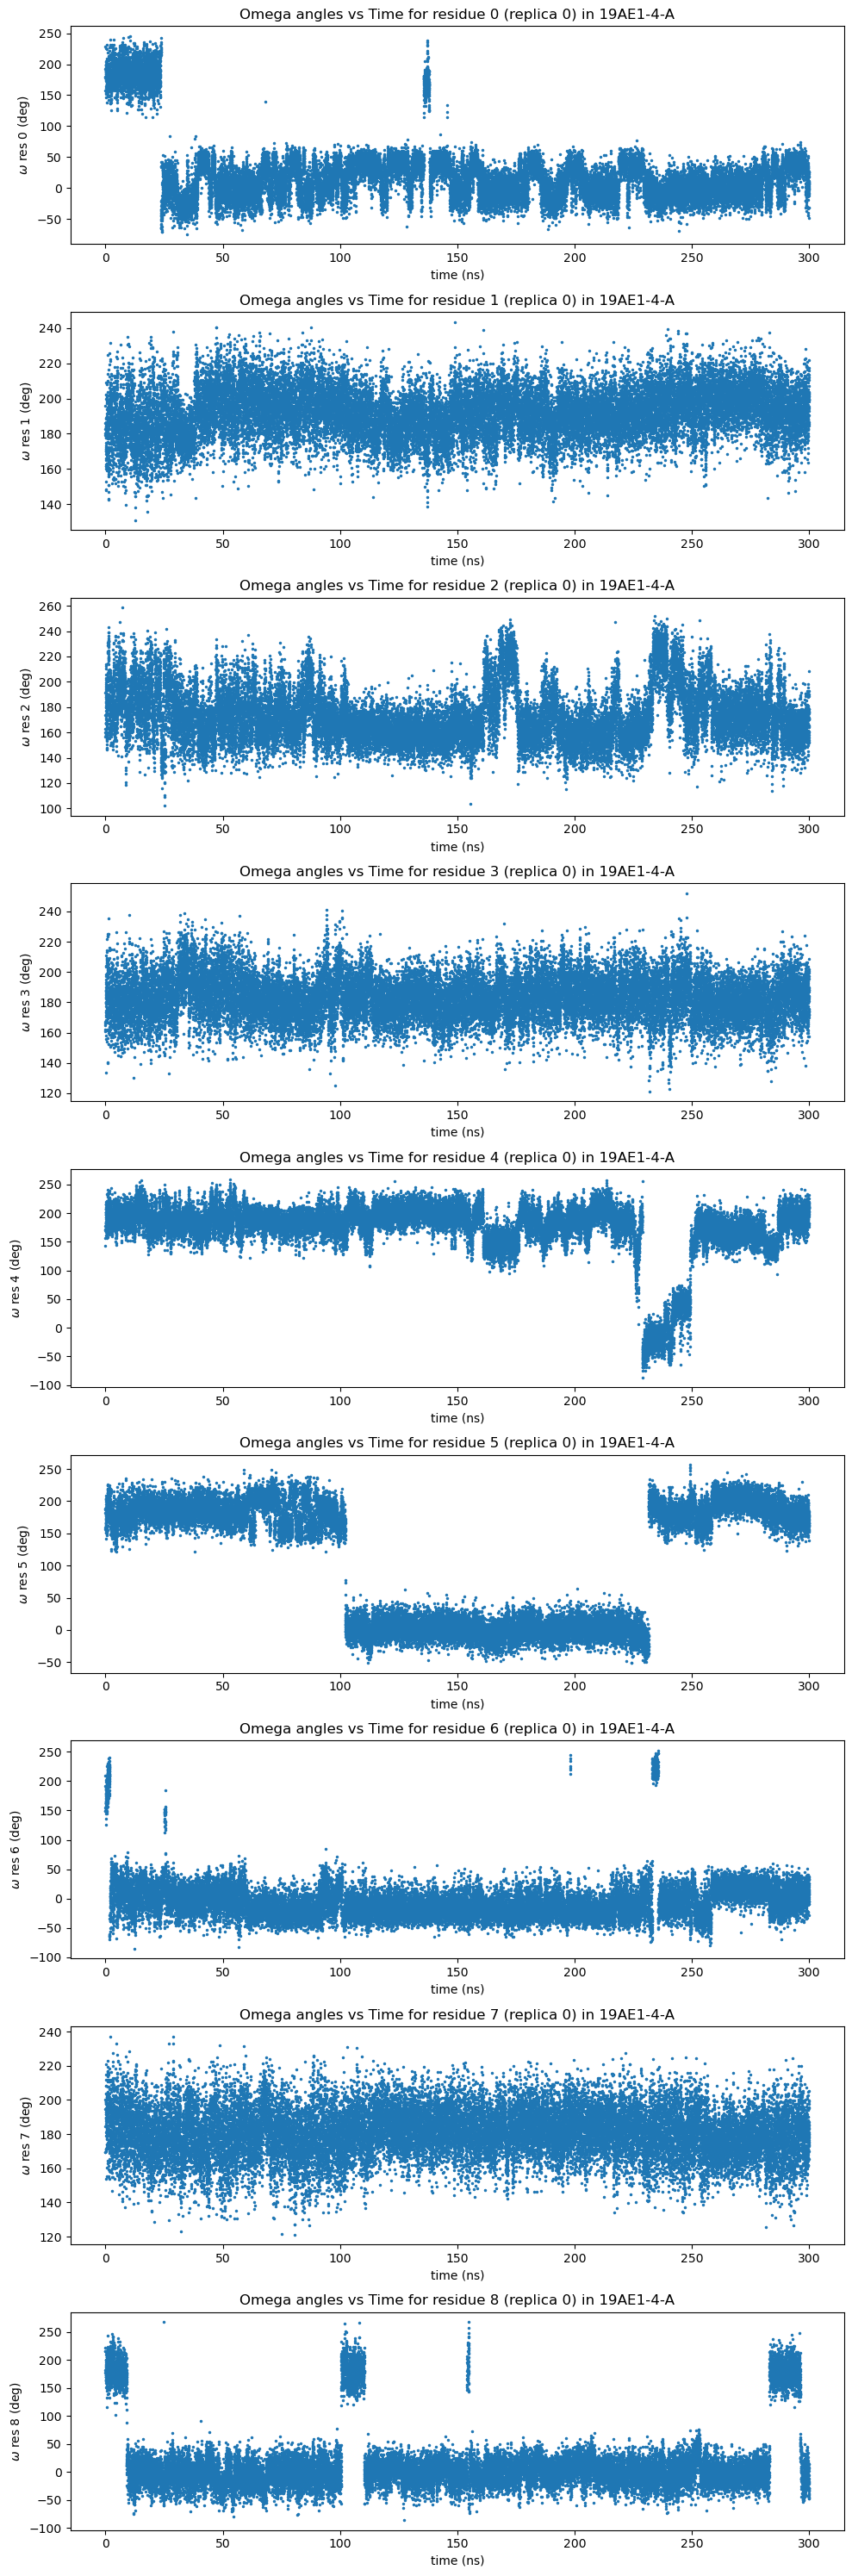

In [12]:
# Plotting the omegas 
omegas = (omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

start = 0
nsnaps = 30000
t = np.arange(start, nsnaps) * 0.01 # Tims axis in ns 
residues_to_plot = np.array(range(9))
num_residues = len(residues_to_plot)

plt.figure(figsize=(10, 30))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omegas[start:nsnaps, residue], '.', ms=3)
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ res {residue} (deg)')
    plt.title(f'Omega angles vs Time for residue {residue} (replica 0) in 19AE1-4-A')
plt.tight_layout()
plt.show()

### Clustering Method

In [27]:
regularspace_estimator = RegularSpace(
    dmin=180,  # minimum distance between cluster centers, 180 degree
    max_centers=32,  # maximum number of cluster centers
    n_jobs=8
)

kmean_estimator = KMeans(
    n_clusters=2,  # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=100000000,  # don't actually perform the optimization, just place centers
    fixed_seed=13, # Treat this as hyperparameter 
    n_jobs=8,
    progress=tqdm
)

In [28]:
# Fit the omegas data into model 
clustering = kmean_estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

### The population of each cluster:

In [29]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())

for label, frequency in sorted_counts.items():
    precentage = (frequency / total_counts) * 100 
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

Assignment 0: 4765, 15.88%
Assignment 1: 25236, 84.12%


TypeError: hexbin() got multiple values for argument 'bins'

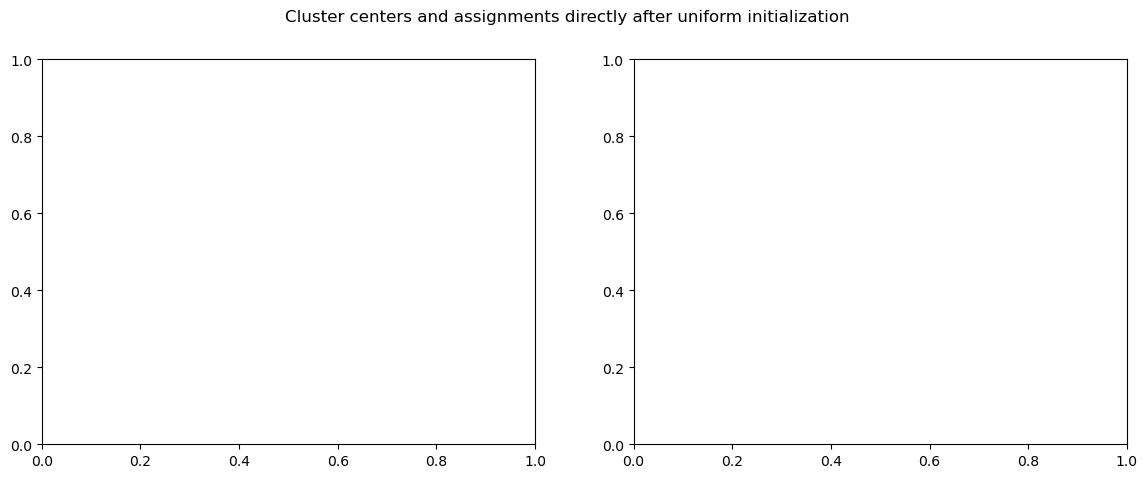

In [30]:
# Plotting the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

# Adjust display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270

# First plot: hexbin and cluster centers
ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('on')
ax1.set_xlim(x_min, x_max)  # Set x-axis range
ax1.set_ylim(y_min, y_max)  # Set y-axis range
ax1.set_title('cluster centers')

# Second plot: scatter plot of assignments
ax2.scatter(*(omegas.T), c=assignments, cmap='tab20c')
ax2.axis('on')
ax2.set_xlim(x_min, x_max)  # Set x-axis range
ax2.set_ylim(y_min, y_max)  # Set y-axis range
ax2.set_title('assignments of data to centers')

# Show the plots
plt.show()

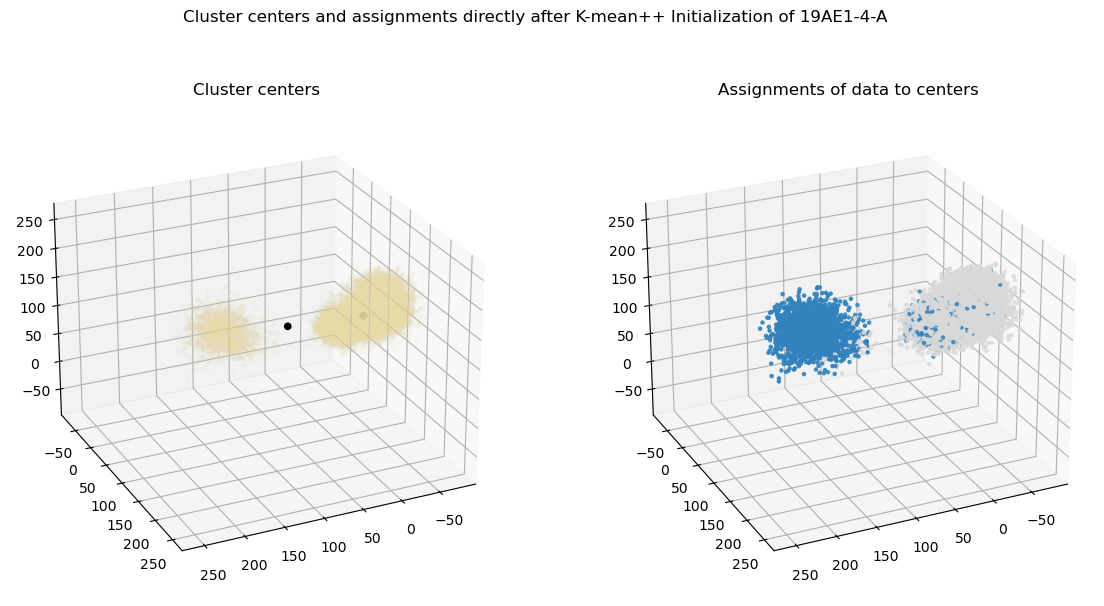

In [31]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate the Inertias:

$$
\sum_{i=1}^{k} \sum_{x_j \in S_i} \|\mathbf{x}_j - \mu_i\|^2
$$


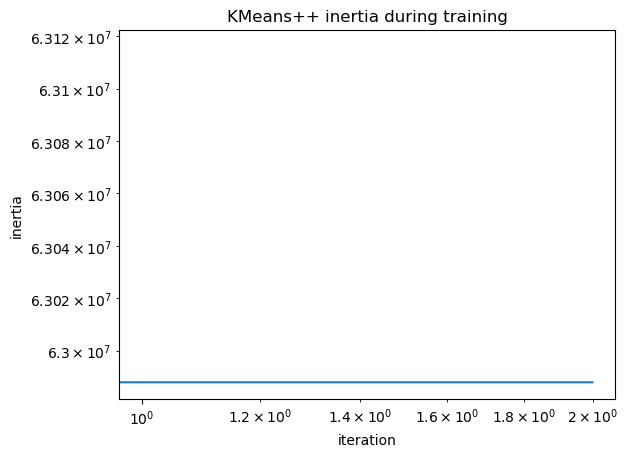

In [29]:
plt.loglog(clustering.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans++ inertia during training");